In [1]:
import sys, cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import collections
from dataclasses import dataclass
from tqdm.notebook import tnrange, tqdm
from functools import reduce

# Reading Dumped data

In [2]:
with open('sortedFish.pik','rb') as f:
    sortedFish=pickle.load(f)

posU=sortedFish[0]
nonOverlappingRange=sortedFish[1]
fishU=sortedFish[2]

fishU=frame,fish,pixel,[row,col,grey]

262 30 113.57956808685125 111.0


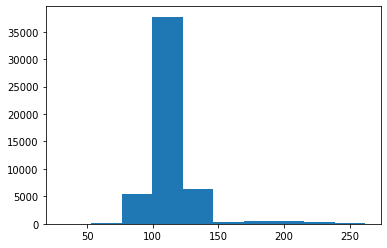

(array([    0,     1,     2, ..., 51211, 51212, 51213], dtype=int64),)


In [3]:
# Pixels should be over 150, here's how many are.
pixelCount=[]
for i in range(len(fishU)):
    pixelCount.append(len(fishU[i][0]))
print(max(pixelCount),min(pixelCount),np.mean(pixelCount),np.median(pixelCount))
plt.hist(pixelCount)
plt.show()
pixelCount=np.array(pixelCount)
print(np.where(pixelCount<150))

# Creating a distance histogram out of the sorted data

### Creating histograms for the first fish over the first nonoverlapping range

### Function to create histograms

In [4]:
def histMaker(histData,bins1,bins2):
    '''
    Creates a 2d histogram.
    
    Input:
        histData:Either histSum or histDif. Some sort of array?
        bins1:The distance bins. np.linspace(int,int,int)
        bins2:The sum/difference bins. np.linspace(int,int,int)
    '''
    #fig=plt.figure(figsize=(5,5))
    
    plt.imshow(histData[:,::-1].T,extent=[bins1[0], bins1[-1], bins2[0], bins2[-1]],aspect='auto')
    plt.colorbar()
    
    #plt.show()

### Creating histograms for two fish over the first n nonoverlapping ranges.

In [5]:
def binSetter(x,y,z):
    '''
    
    '''
    global binsDist
    global binsDif
    global binsSum
    global histSum
    global histDif
    
    binsDist=np.linspace(0,30,x)
    binsDif=np.linspace(0,50,y)
    binsSum=np.linspace(150,350,z)
    histSum=np.zeros((len(binsDist)-1,len(binsSum)-1))
    histDif=np.zeros((len(binsDist)-1,len(binsDif)-1))

In [6]:
binSetter(30,50,200)

Reenable this cell

In [7]:
with open('histLists.pik','rb') as f:
    histLists=pickle.load(f)

#globals().update(histLists)
histSumList=histLists[0]
histDifList=histLists[1]

Reenable this cell

### Checking distances between the histograms

# Use scipy.spatial.distance.cdist instead?

In [8]:
def swapStatus(histList):
    '''
    Detext swaps between consecutive nonOverlappingRanges based on brightness sum and difference.
    
    Input:
        histList: . Dictionary
    
    Output:
        Int. 0 if no swaps, 1 if swapped, 2 if overlapping.
    '''
    
    #histList=list(histDict.values())
    
    distanceMatrix=[np.linalg.norm(histList[0,0]-histList[1,0]),
        np.linalg.norm(histList[1,0]-histList[1,1]),
        np.linalg.norm(histList[0,1]-histList[1,0]),
        np.linalg.norm(histList[0,1]-histList[1,1])]
    
    swapCriteron=(distanceMatrix[0]+distanceMatrix[1])-(distanceMatrix[2]+distanceMatrix[3])
    if abs(swapCriteron)<1e-10:
        return 2 #Overlapping
    elif swapCriteron>0:
        return 1 #Swapped
    elif swapCriteron<0:
        return 0 #Normal
    else:
        return -1

In [9]:
swapStatus(histSumList)

1

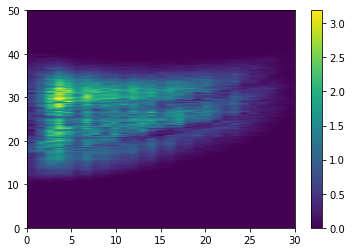

In [10]:
dH=np.mean([np.absolute(histSumList[i,0]-histSumList[0,1]) for i in range(2)],axis=0)
histMaker(dH,binsDist,binsDif)
plt.show()

H=histSumList
distMat=np.array([[H[1,0]-H[0,0],H[1,0]-H[0,1]],
                 [H[1,1]-H[0,0],H[1,1]-H[0,1]]])
#multiply by dH, sum

## Creating a graph on onaxis distances vs off axis distances

In [11]:
def swapMatrix(histList):
    '''
    Creates a list of pairs consisting of the onAxxiss distance and the off axis distance for a given set of histograms.
    
    Input:
    
    Output: [[,],[,]]
    '''
    nOverlap=list(histList.keys())[-1][0]
    
    distanceMatrix=[]
    for i in range(nOverlap):
        distSame=np.linalg.norm(histList[i+1,0]-histList[i,0])+np.linalg.norm(histList[i+1,1]-histList[i,1])
        distDiff=np.linalg.norm(histList[i+1,1]-histList[i,0])+np.linalg.norm(histList[i+1,0]-histList[i,1])
        distanceMatrix.append([distSame,distDiff])
    
    return(distanceMatrix)

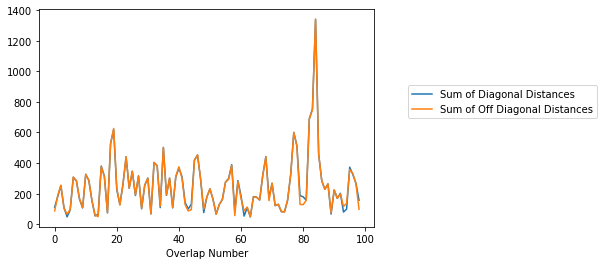

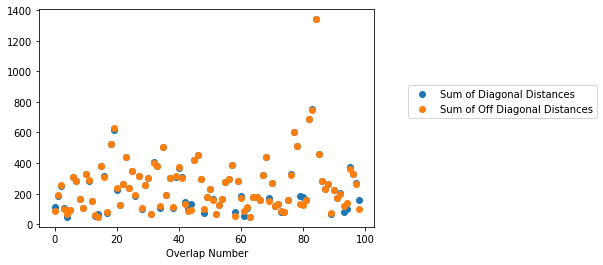

In [12]:
distanceMatrix=swapMatrix(histSumList)

plt.plot(np.asarray(distanceMatrix).T[0],label='Sum of Diagonal Distances')
plt.plot(np.asarray(distanceMatrix).T[1],label='Sum of Off Diagonal Distances')
plt.xlabel('Overlap Number')
plt.legend(loc=(1.1,.5))
plt.show()

plt.scatter(np.linspace(0,len(np.asarray(distanceMatrix).T[0])-1,len(np.asarray(distanceMatrix).T[0])),np.asarray(distanceMatrix).T[0],label='Sum of Diagonal Distances')
plt.scatter(np.linspace(0,len(np.asarray(distanceMatrix).T[1])-1,len(np.asarray(distanceMatrix).T[1])),np.asarray(distanceMatrix).T[1],label='Sum of Off Diagonal Distances')
plt.xlabel('Overlap Number')
plt.legend(loc=(1.1,.5))
plt.show()

In [13]:
def swapLister(distanceMatrix):
    '''
    
    '''
    swapList=[]
    
    for i in range(len(distanceMatrix)):
        if distanceMatrix[i][1]>distanceMatrix[i][0]:
            swapList.append(i)
        
    return(swapList)

In [14]:
print(swapLister(swapMatrix(histSumList)))

[1, 2, 4, 5, 6, 8, 9, 11, 13, 17, 19, 20, 26, 28, 31, 34, 36, 37, 38, 39, 40, 46, 47, 48, 49, 53, 61, 62, 63, 65, 70, 72, 73, 75, 85, 86, 87, 89, 90, 93, 94, 96]


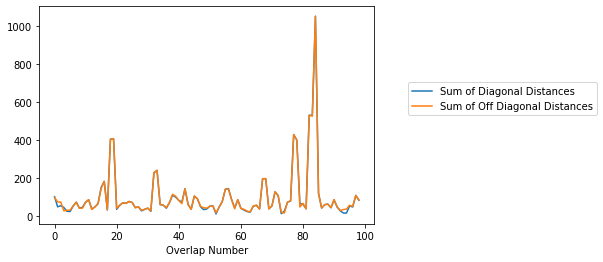

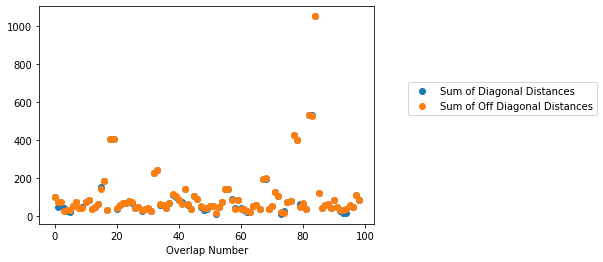

In [15]:
distanceMatrix=swapMatrix(histDifList)

plt.plot(np.asarray(distanceMatrix).T[0],label='Sum of Diagonal Distances')
plt.plot(np.asarray(distanceMatrix).T[1],label='Sum of Off Diagonal Distances')
plt.xlabel('Overlap Number')
plt.legend(loc=(1.1,.5))
plt.show()

plt.scatter(np.linspace(0,len(np.asarray(distanceMatrix).T[0])-1,len(np.asarray(distanceMatrix).T[0])),np.asarray(distanceMatrix).T[0],label='Sum of Diagonal Distances')
plt.scatter(np.linspace(0,len(np.asarray(distanceMatrix).T[1])-1,len(np.asarray(distanceMatrix).T[1])),np.asarray(distanceMatrix).T[1],label='Sum of Off Diagonal Distances')
plt.xlabel('Overlap Number')
plt.legend(loc=(1.1,.5))
plt.show()

In [16]:
print(swapLister(swapMatrix(histDifList)))

[1, 2, 4, 5, 6, 11, 13, 16, 17, 18, 19, 20, 24, 25, 27, 28, 31, 34, 35, 36, 37, 38, 39, 43, 46, 47, 48, 49, 52, 59, 61, 62, 63, 64, 65, 68, 69, 72, 73, 75, 76, 77, 80, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]


#### Finds differences/intersections between the sum and difference swap sets

In [17]:
print(set(swapLister(swapMatrix(histSumList)))^set(swapLister(swapMatrix(histDifList))))

{8, 9, 16, 18, 24, 25, 26, 27, 35, 40, 43, 52, 53, 59, 64, 68, 69, 70, 76, 77, 80, 85, 91, 92, 95, 97, 98}


In [18]:
f=open('overlapCheck.txt','r')
#fr=f.read()
manualOverlapArray=[]
for line in f:
    line=line.strip().split(',')
    manualOverlapArray.append([int(x) for x in line ])
print(manualOverlapArray)

[[0, 1], [1, 0], [2, 0], [3, 1], [4, 0], [5, 0], [6, 0], [7, 1], [8, 0], [9, 0], [10, 0], [11, 0], [12, 1], [13, 0], [14, 1], [15, 1], [16, 0], [17, 0], [18, 0], [19, 0], [20, 0], [21, 1], [22, 0], [23, 0], [24, 0], [25, 1], [26, 1], [27, 0], [28, 0], [29, 0], [30, 1], [31, 0], [32, 1], [33, 1], [34, 0], [35, 0], [36, 0], [37, 0], [38, 0], [39, 0], [40, 1], [41, 1], [42, 0], [43, 1], [44, 1], [45, 0], [46, 0], [47, 0], [48, 0], [49, 0], [50, 1], [51, 1], [52, 0], [53, 1], [54, 1], [55, 0], [56, 1], [57, 1], [58, 1], [59, 0]]


In [19]:
reduce(np.intersect1d,(swapLister(swapMatrix(histDifList)),swapLister(swapMatrix(histSumList)),manualOverlapArray))

array([ 1,  2,  4,  5,  6, 11, 13, 17, 19, 20, 28, 31, 34, 36, 37, 38, 39,
       46, 47, 48, 49])

## Allow definitions of custom  bins.

In [25]:
def binMaker(x,n):
    '''
    
    '''
    
    for i in range(n):
        print("x",x.shape)
        #while ((x.shape[1]%2!=0)&(x.shape[0]%2!=0)):
        while (((x.shape[1]%2!=0)&(x.shape[0]%2!=0))==True):
            #print("\t loop")
            print("\t loop",((x.shape[1]%2!=0)&(x.shape[0]%2!=0)))
            if(x.shape[0]%2!=0):
                x[-2,:]=x[-1,:]+x[-2,:]
                x=np.delete(x,-1,0)
                print("\t",x.shape)

            if(x.shape[1]%2!=0):
                x[:,-2]=x[:,-1]+x[:,-2]
                x=x[:,:-1]
                print("\t",x.shape)
            print("\t",((x.shape[1]%2!=0)&(x.shape[0]%2!=0)))

        print("not loop")    
        y=x[::2,:]+x[1::2,:]
        print("y",y.shape)
        # y=y[::2,:]+y[1::2,:]
        # print(y)
        z=y[:,::2]+y[:,1::2]
        print("z",z.shape)
        x=z
        print("i",i,"\n")

In [26]:
binMaker(histSumList[0,0],3)

x (29, 199)
	 loop True
	 (28, 199)
	 (28, 198)
	 False
not loop
y (14, 198)
z (14, 99)
i 0 

x (14, 99)
not loop
y (7, 99)


ValueError: operands could not be broadcast together with shapes (7,50) (7,49) 

In [22]:
x=np.random.randint(0,10,(29,199))
print((x.shape[0]%2!=0))
print((x.shape[1]%2!=0))
print((x.shape[1]%2!=0)&(x.shape[0]%2!=0))

True
True
True
